In [1]:
import json
import argparse
from logging import raiseExceptions

import numpy as np
from sklearn.model_selection import train_test_split
#
from model import *
from preset import preset
from load_data import load_data_x, load_data_y, encode_data_y
from utils import *
#
import os
import time
import torch
import numpy as np
from sklearn.model_selection import train_test_split
#
import torch.nn as nn
from torch.utils.data import TensorDataset
from ptflops import get_model_complexity_info
from itertools import permutations
from sklearn.metrics import classification_report, accuracy_score
from scipy.optimize import linear_sum_assignment
from train import train
from preset import preset
import torch.nn.functional as F
from utils import *
import wandb
device = torch.device("cuda")

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

def analyze_position_bias(predictions, actuals):
    """Analyze bias in predictions at each position"""
    num_positions = predictions.shape[1]
    position_stats = []
    
    for pos in range(num_positions):
        pred_at_pos = predictions[:, pos]
        actual_at_pos = actuals[:, pos]
        
        # Calculate statistics
        stats = {
            'position': pos,
            'avg_pred': pred_at_pos.mean(),
            'avg_actual': actual_at_pos.mean(),
            'bias': pred_at_pos.mean() - actual_at_pos.mean(),
            'accuracy': (pred_at_pos == actual_at_pos).mean()
        }
        position_stats.append(stats)
        
    return position_stats

def analyze_activity_bias(predictions, actuals):
    """Analyze bias in predictions for each activity"""
    activity_counts = defaultdict(lambda: {'pred': 0, 'actual': 0})
    
    for i in range(9):  # 9 activities
        pred_count = (predictions == i).sum()
        actual_count = (actuals == i).sum()
        
        activity_counts[i].update({
            'pred': pred_count,
            'actual': actual_count,
            'bias_ratio': pred_count / max(actual_count, 1)
        })
    
    return activity_counts

def analyze_sequence_patterns(predictions, actuals):
    """Analyze common sequence patterns and their accuracy"""
    sequence_stats = defaultdict(lambda: {'count': 0, 'correct': 0})
    
    for pred_seq, actual_seq in zip(predictions, actuals):
        pred_key = tuple(pred_seq)
        actual_key = tuple(actual_seq)
        
        sequence_stats[actual_key]['count'] += 1
        if pred_key == actual_key:
            sequence_stats[actual_key]['correct'] += 1
    
    return sequence_stats

def plot_confusion_matrix(predictions, actuals, title="Confusion Matrix"):
    """Plot confusion matrix for activities"""
    cm = np.zeros((9, 9))  # 9x9 for 9 activities
    
    for i in range(len(predictions)):
        for j in range(predictions.shape[1]):
            cm[actuals[i, j], predictions[i, j]] += 1
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    return cm

def analyze_transition_bias(predictions, actuals):
    """Analyze bias in activity transitions"""
    pred_transitions = defaultdict(int)
    actual_transitions = defaultdict(int)
    
    for i in range(len(predictions)):
        for j in range(predictions.shape[1] - 1):
            pred_trans = (predictions[i, j], predictions[i, j+1])
            actual_trans = (actuals[i, j], actuals[i, j+1])
            
            pred_transitions[pred_trans] += 1
            actual_transitions[actual_trans] += 1
    
    return pred_transitions, actual_transitions



In [3]:
preset["nn"]["num_obj_queries"]

5

In [4]:
def master_splitter(preset, var_task, var_model, var_users):
    env_data_x_train = []
    env_data_x_test = []
    env_data_y_train = []
    env_data_y_test = []
    for env in preset["data"]["environment"]:
        data_pd_y = load_data_y(preset["path"]["data_y"],
                                var_environment=[env],
                                var_wifi_band=preset["data"]["wifi_band"],
                                var_num_users=var_users)
        #
        var_label_list = data_pd_y["label"].to_list()
        #
        ## load CSI amplitude
        X = load_data_x(preset["path"]["data_x"], var_label_list)


        y = encode_data_y(data_pd_y, var_task)

        if var_model == "THAT_MULTI_HEAD":
            y = reduce_dataset(y)  # CHECKKKKKKKK HEREEEEEE
        elif var_model == "THAT_ENCODER" or var_model == "DETR":
            y = reduce_dataset(y, preset["nn"]["num_obj_queries"])  # CHECKKKKKKKK HEREEEEEE
        elif var_model == "THAT_COUNT_CONSTRAINED":
            y_red = reduce_dataset(y)
            y = y_red.sum(axis=1)
        else:
            pass

        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=0.2,
                                                            shuffle=True,
                                                            random_state=103)
        # np.random.randint()
        env_data_x_train.append(X_train)
        env_data_x_test.append(X_test)
        env_data_y_train.append(y_train)
        env_data_y_test.append(y_test)
    
    data_x_train = np.concatenate(env_data_x_train, axis = 0)
    data_x_test = np.concatenate(env_data_x_test, axis = 0)
    data_y_train = np.concatenate(env_data_y_train, axis = 0)
    data_y_test = np.concatenate(env_data_y_test, axis = 0)


    return data_x_train, data_x_test, data_y_train, data_y_test

In [5]:
load_path = "/home/amirmhd/Documents/multi_modal_CSI/benchmark/wifi_csi/results/model_0/PT_empty_room_DETR.pth"
var_task = preset["task"]
var_model = preset["model"]
var_repeat = preset["repeat"]
var_users = ["0","1", "2", "3", "4", "5"]

In [6]:
data_train_x, data_test_x, data_train_y, data_test_y = master_splitter(preset, var_task, var_model, var_users)

In [7]:
data_train_x.shape


(1504, 3000, 3, 3, 30)

In [10]:
data_train_x = data_train_x.reshape(data_train_x.shape[0], data_train_x.shape[1], -1)
data_test_x = data_test_x.reshape(data_test_x.shape[0], data_test_x.shape[1], -1)
var_x_shape, var_y_shape = data_train_x[0].shape, [data_train_y[0].shape[1]]
print("New shape of the data")
print(data_train_x.shape)
model_detr = DETR_MultiUser(var_x_shape,
                            var_y_shape,
                            num_decoder_layers=preset["nn"]["num_decoder_layers"],
                            temp_cross=preset["nn"]["cross_attention_temp"],
                            num_queries=preset["nn"]["num_obj_queries"],
                            dim_feedforward=preset["nn"]["dim_FFN"]).to(device)

New shape of the data
(1504, 3000, 270)


In [11]:
state_dict = torch.load(load_path, map_location=device)
model_detr.load_state_dict(state_dict)



<All keys matched successfully>

In [31]:
all_layers_pred= model_detr(torch.tensor(data_test_x).to(device))

all_layers_pred = all_layers_pred.detach().cpu()

OutOfMemoryError: CUDA out of memory. Tried to allocate 4.54 GiB (GPU 0; 9.76 GiB total capacity; 9.28 GiB already allocated; 37.94 MiB free; 9.37 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [12]:
all_layers_pred_train = model_detr(torch.tensor(data_train_x[0:300]).to(device))

all_layers_pred_train = all_layers_pred_train.detach().cpu()

In [16]:
pred_train = all_layers_pred_train[-1].detach().cpu().numpy()
y_train = data_train_y[0:300].argmax(axis=2)
y_pred_train = pred_train.argmax(axis=2)


In [17]:
performance_metrics(data_train_y[0:300], all_layers_pred_train.detach().cpu())

{'total_error': 0.16666666666666666,
 'perfect_prediction_percentage': 91.33333333333333,
 'accuracy': 0.9826192161666916,
 'error_per_person': [0.05714285714285714,
  0.19148936170212766,
  0.275,
  0.25925925925925924,
  0.23809523809523808],
 'mean_count_error': 0.013333333333333334,
 'counting_error_perPerson': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,


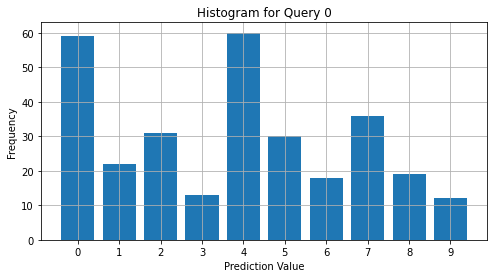

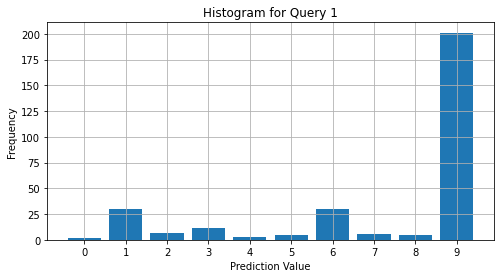

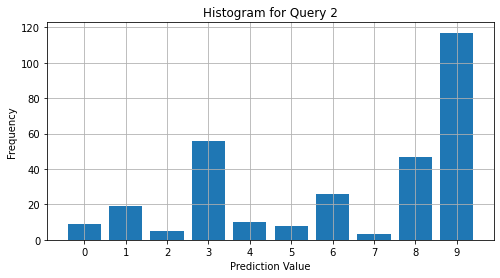

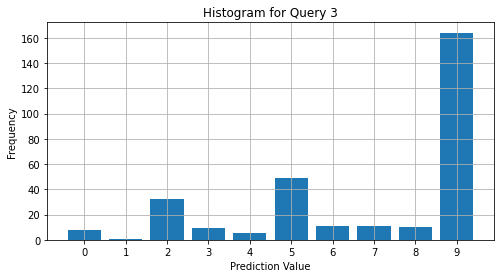

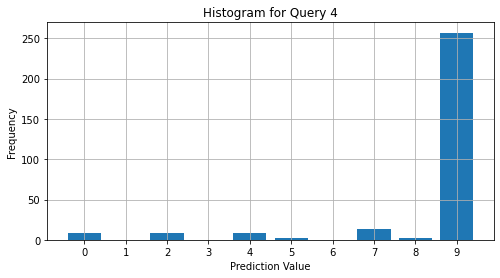

In [18]:
import matplotlib.pyplot as plt

num_queries = preset["nn"]["num_obj_queries"]

for query_idx in range(num_queries):
    plt.figure(figsize=(8, 4))
    plt.hist(y_pred_train[:, query_idx], bins=range(11), align='left', rwidth=0.8)  # range(11) creates edges 0,1,2,...,10
    
    # Set x-axis ticks to show discrete values 0-9
    plt.xticks(range(10))
    
    plt.xlabel('Prediction Value')
    plt.ylabel('Frequency')
    plt.title(f'Histogram for Query {query_idx}')
    plt.grid(True)
    plt.show()

In [16]:
pred = all_layers_pred[-1].detach().cpu().numpy()
y = data_test_y.argmax(axis=2)
y_pred = pred.argmax(axis=2)


In [17]:
performance_metrics(data_test_y, all_layers_pred.detach().cpu())

{'total_error': 2.1193633952254642,
 'perfect_prediction_percentage': 33.15649867374005,
 'accuracy': 0.7860166082466693,
 'error_per_person': [1.1544715447154472,
  1.8867924528301887,
  2.55,
  3.1147540983606556,
  3.8214285714285716],
 'mean_count_error': 0.007957559681697613,
 'counting_error_perPerson': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
      

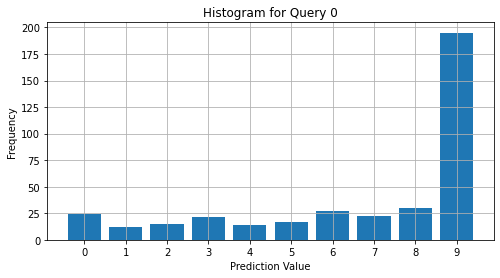

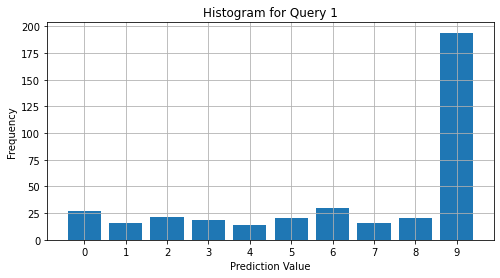

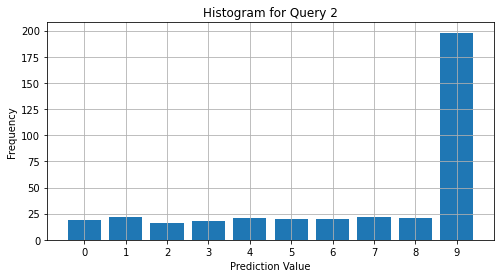

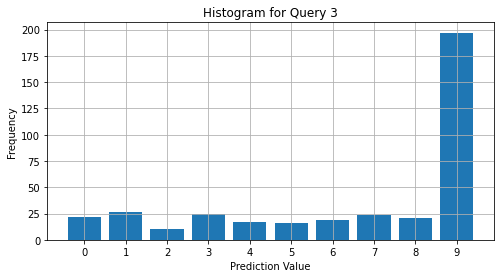

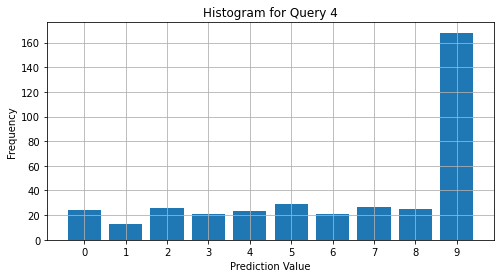

In [18]:
import matplotlib.pyplot as plt

num_queries = preset["nn"]["num_obj_queries"]

for query_idx in range(num_queries):
    plt.figure(figsize=(8, 4))
    plt.hist(y[:, query_idx], bins=range(11), align='left', rwidth=0.8)  # range(11) creates edges 0,1,2,...,10
    
    # Set x-axis ticks to show discrete values 0-9
    plt.xticks(range(10))
    
    plt.xlabel('Prediction Value')
    plt.ylabel('Frequency')
    plt.title(f'Histogram for Query {query_idx}')
    plt.grid(True)
    plt.show()

(377, 5)

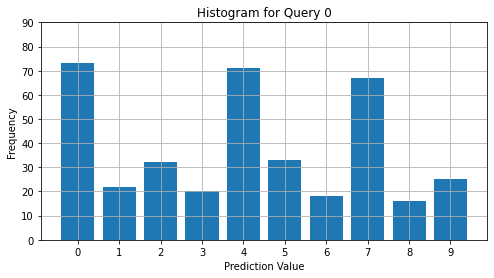

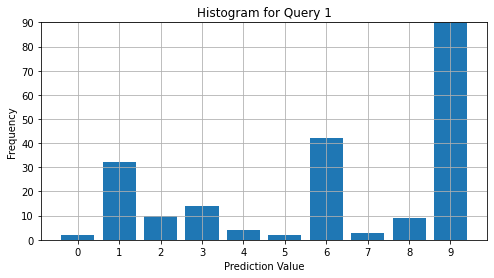

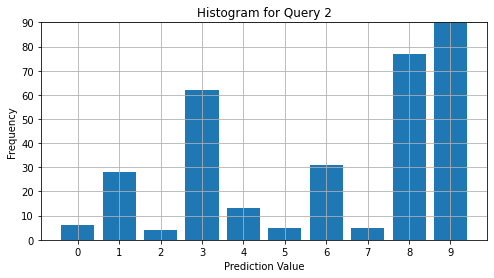

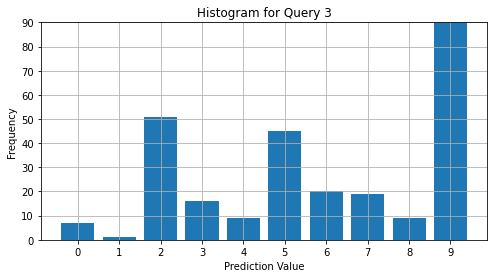

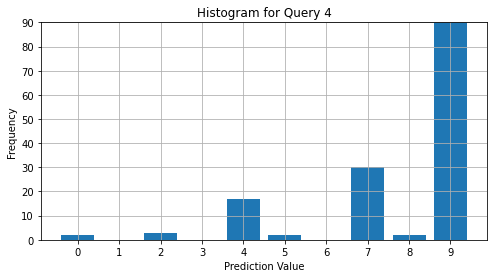

In [28]:
import matplotlib.pyplot as plt

num_queries = preset["nn"]["num_obj_queries"]
for query_idx in range(num_queries):
    plt.figure(figsize=(8, 4))
    plt.hist(y_pred[:, query_idx], bins=range(11), align='left', rwidth=0.8)  # range(11) creates edges 0,1,2,...,10
    
    # Set x-axis ticks to show discrete values 0-9
    plt.xticks(range(10))
    plt.ylim(0, 90)

    plt.xlabel('Prediction Value')
    plt.ylabel('Frequency')
    plt.title(f'Histogram for Query {query_idx}')
    plt.grid(True)
    plt.show()

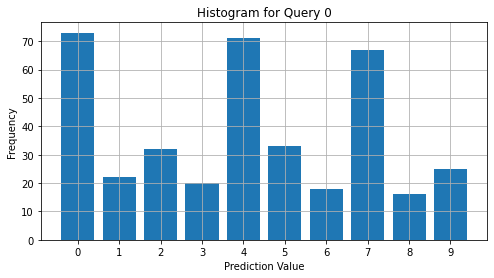

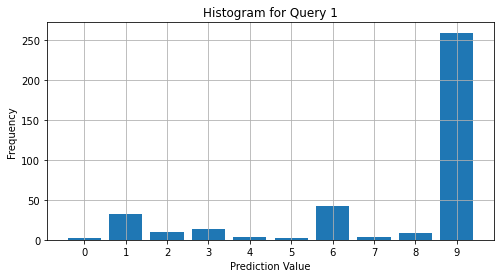

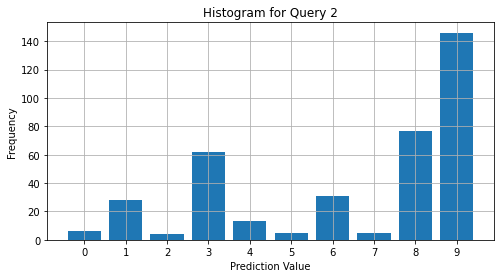

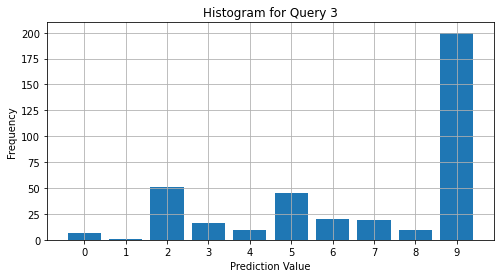

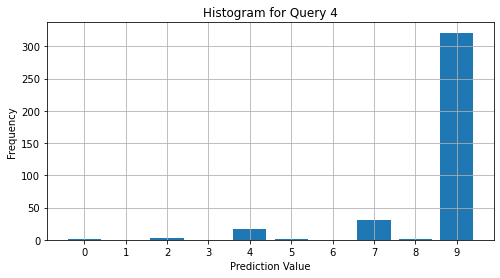

In [19]:
import matplotlib.pyplot as plt

num_queries = preset["nn"]["num_obj_queries"]

for query_idx in range(num_queries):
    plt.figure(figsize=(8, 4))
    plt.hist(y_pred[:, query_idx], bins=range(11), align='left', rwidth=0.8)  # range(11) creates edges 0,1,2,...,10
    
    # Set x-axis ticks to show discrete values 0-9
    plt.xticks(range(10))
    
    plt.xlabel('Prediction Value')
    plt.ylabel('Frequency')
    plt.title(f'Histogram for Query {query_idx}')
    plt.grid(True)
    plt.show()

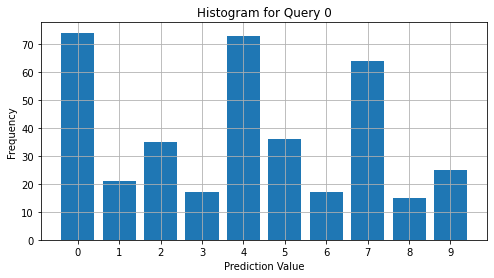

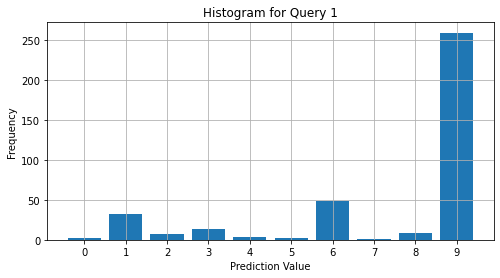

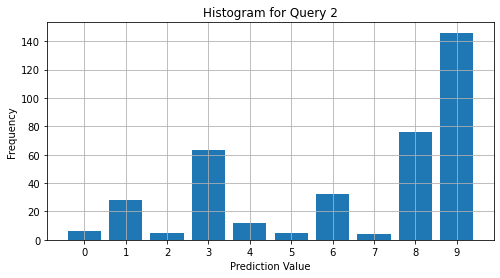

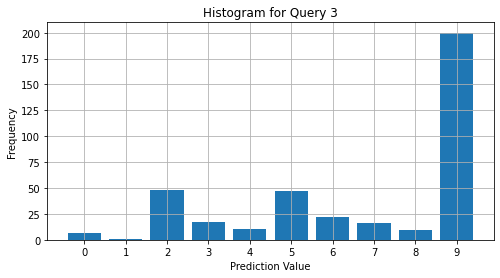

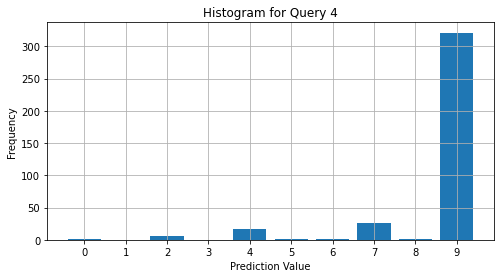

In [56]:
import matplotlib.pyplot as plt

num_queries = preset["nn"]["num_obj_queries"]

for query_idx in range(num_queries):
    plt.figure(figsize=(8, 4))
    plt.hist(y_pred[:, query_idx], bins=range(11), align='left', rwidth=0.8)  # range(11) creates edges 0,1,2,...,10
    
    # Set x-axis ticks to show discrete values 0-9
    plt.xticks(range(10))
    
    plt.xlabel('Prediction Value')
    plt.ylabel('Frequency')
    plt.title(f'Histogram for Query {query_idx}')
    plt.grid(True)
    plt.show()

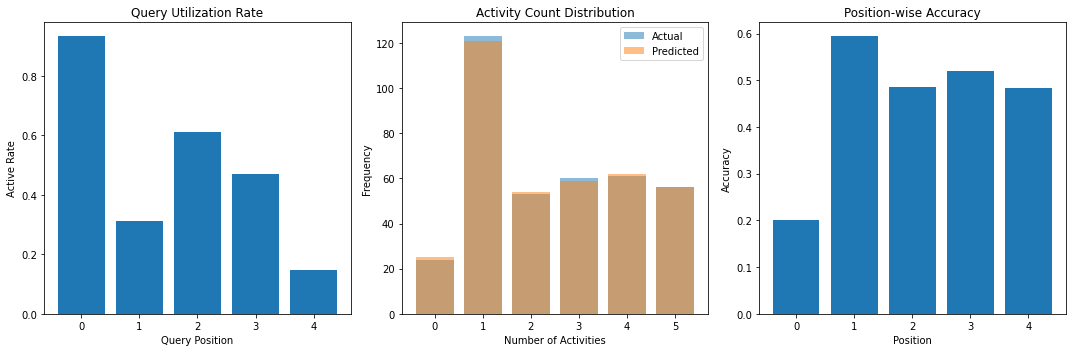


Query Utilization Analysis:
Query 0: Active Rate = 0.934 (Actual: 0.483)
Query 1: Active Rate = 0.313 (Actual: 0.485)
Query 2: Active Rate = 0.613 (Actual: 0.475)
Query 3: Active Rate = 0.469 (Actual: 0.477)
Query 4: Active Rate = 0.149 (Actual: 0.554)

Activity Count Analysis:
Average predicted activities: 2.48
Average actual activities: 2.47
Count accuracy: 0.992


In [30]:
results = run_analysis(all_layers_pred.detach().cpu().numpy(), data_test_y)

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

def process_predictions(predict_test_y, data_test_y):
    """
    Process DETR model predictions to match expected format
    Args:
        predict_test_y: Model output of shape (num_decoder_layers, batch_size, num_queries, num_classes)
        data_test_y: Ground truth of shape (batch_size, num_queries, num_classes)
    Returns:
        predictions and actuals in processed format
    """
    # Take predictions from last decoder layer
    predictions = predict_test_y[-1]  # Shape: (batch_size, num_queries, num_classes)
    
    # Convert to class indices
    pred_indices = np.argmax(predictions, axis=-1)  # Shape: (batch_size, num_queries)
    true_indices = np.argmax(data_test_y, axis=-1)  # Shape: (batch_size, num_queries)
    
    return pred_indices, true_indices

def analyze_position_bias(predictions, actuals):
    """
    Analyze bias in predictions at each query position
    predictions: shape (batch_size, num_queries)
    actuals: shape (batch_size, num_queries)
    """
    num_queries = predictions.shape[1]
    position_stats = []
    
    for pos in range(num_queries):
        pred_at_pos = predictions[:, pos]
        actual_at_pos = actuals[:, pos]
        
        # Calculate per-position statistics
        stats = {
            'position': pos,
            'avg_pred': pred_at_pos.mean(),
            'avg_actual': actual_at_pos.mean(),
            'bias': pred_at_pos.mean() - actual_at_pos.mean(),
            'accuracy': (pred_at_pos == actual_at_pos).mean(),
            'no_activity_pred': (pred_at_pos == 9).mean(),  # Assuming 9 is no-activity class
            'no_activity_actual': (actual_at_pos == 9).mean()
        }
        position_stats.append(stats)
        
    return position_stats

def analyze_query_patterns(predictions, actuals):
    """
    Analyze how different queries are being utilized
    """
    num_queries = predictions.shape[1]
    query_stats = []
    
    for query in range(num_queries):
        # Get all predictions and actuals for this query
        query_preds = predictions[:, query]
        query_acts = actuals[:, query]
        
        # Calculate statistics
        stats = {
            'query': query,
            'active_rate_pred': (query_preds != 9).mean(),  # How often query predicts an activity
            'active_rate_actual': (query_acts != 9).mean(),
            'most_common_pred': np.bincount(query_preds).argmax(),
            'most_common_actual': np.bincount(query_acts).argmax(),
            'accuracy': (query_preds == query_acts).mean()
        }
        query_stats.append(stats)
    
    return query_stats

def analyze_activity_count_bias(predictions, actuals):
    """
    Analyze bias in counting number of activities
    """
    # Count active predictions/actuals per sample
    pred_counts = (predictions != 9).sum(axis=1)  # Count non-no-activity predictions
    actual_counts = (actuals != 9).sum(axis=1)
    
    count_stats = {
        'avg_pred_count': pred_counts.mean(),
        'avg_actual_count': actual_counts.mean(),
        'count_bias': pred_counts.mean() - actual_counts.mean(),
        'count_accuracy': (pred_counts == actual_counts).mean(),
        'count_distribution': {
            'predicted': np.bincount(pred_counts, minlength=6),
            'actual': np.bincount(actual_counts, minlength=6)
        }
    }
    
    return count_stats

def run_analysis(predict_test_y, data_test_y):
    """Run comprehensive analysis on model predictions"""
    # Process predictions and ground truth
    predictions, actuals = process_predictions(predict_test_y, data_test_y)
    
    # Run analyses
    position_stats = analyze_position_bias(predictions, actuals)
    query_stats = analyze_query_patterns(predictions, actuals)
    count_stats = analyze_activity_count_bias(predictions, actuals)
    
    # Visualizations
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Query utilization
    plt.subplot(131)
    query_active_rates = [s['active_rate_pred'] for s in query_stats]
    plt.bar(range(len(query_stats)), query_active_rates)
    plt.title('Query Utilization Rate')
    plt.xlabel('Query Position')
    plt.ylabel('Active Rate')
    
    # Plot 2: Activity count distribution
    plt.subplot(132)
    x = range(6)  # 0 to 5 activities
    plt.bar(x, count_stats['count_distribution']['actual'], alpha=0.5, label='Actual')
    plt.bar(x, count_stats['count_distribution']['predicted'], alpha=0.5, label='Predicted')
    plt.title('Activity Count Distribution')
    plt.xlabel('Number of Activities')
    plt.ylabel('Frequency')
    plt.legend()
    
    # Plot 3: Position-wise accuracy
    plt.subplot(133)
    accuracies = [s['accuracy'] for s in position_stats]
    plt.bar(range(len(position_stats)), accuracies)
    plt.title('Position-wise Accuracy')
    plt.xlabel('Position')
    plt.ylabel('Accuracy')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nQuery Utilization Analysis:")
    for stat in query_stats:
        print(f"Query {stat['query']}: Active Rate = {stat['active_rate_pred']:.3f} (Actual: {stat['active_rate_actual']:.3f})")
    
    print("\nActivity Count Analysis:")
    print(f"Average predicted activities: {count_stats['avg_pred_count']:.2f}")
    print(f"Average actual activities: {count_stats['avg_actual_count']:.2f}")
    print(f"Count accuracy: {count_stats['count_accuracy']:.3f}")
    
    return {
        'position_stats': position_stats,
        'query_stats': query_stats,
        'count_stats': count_stats
    }


In [9]:
class Gaussian_Position(torch.nn.Module):
    #
    ##
    def __init__(self,
                 var_dim_feature,
                 var_dim_time,
                 var_num_gaussian=10):
        #
        ##
        super(Gaussian_Position, self).__init__()
        #
        ## var_embedding: shape (var_dim_k, var_dim_feature)
        var_embedding = torch.zeros([var_num_gaussian, var_dim_feature], dtype=torch.float)
        self.var_embedding = torch.nn.Parameter(var_embedding, requires_grad=True)
        torch.nn.init.xavier_uniform_(self.var_embedding)
        #
        ## var_position: shape (var_dim_time, var_dim_k)
        var_position = torch.arange(0.0, var_dim_time).unsqueeze(1).repeat(1, var_num_gaussian)
        self.var_position = torch.nn.Parameter(var_position, requires_grad=False)
        #
        ## var_mu: shape (1, var_dim_k)
        var_mu = torch.arange(0.0, var_dim_time, var_dim_time / var_num_gaussian).unsqueeze(0)
        self.var_mu = torch.nn.Parameter(var_mu, requires_grad=True)
        #
        ## var_sigma: shape (1, var_dim_k)
        var_sigma = torch.tensor([50.0] * var_num_gaussian).unsqueeze(0)
        self.var_sigma = torch.nn.Parameter(var_sigma, requires_grad=True)

    #
    ##
    def calculate_pdf(self,
                      var_position,
                      var_mu,
                      var_sigma):
        #
        ##
        var_pdf = var_position - var_mu  # (position-mu)
        #
        var_pdf = - var_pdf * var_pdf  # -(position-mu)^2
        #
        var_pdf = var_pdf / var_sigma / var_sigma / 2  # -(position-mu)^2 / (2*sigma^2)
        #
        var_pdf = var_pdf - torch.log(var_sigma)  # -(position-mu)^2 / (2*sigma^2) - log(sigma)
        #
        return var_pdf

    #
    ##
    def forward(self,
                var_input):
        var_pdf = self.calculate_pdf(self.var_position, self.var_mu, self.var_sigma)

        var_pdf = torch.softmax(var_pdf, dim=-1)
        #
        var_position_encoding = torch.matmul(var_pdf, self.var_embedding)
        #
        # print(var_input.shape, var_position_encoding.shape)
        var_output = var_input + var_position_encoding.unsqueeze(0)
        #
        return var_output


#
##
## ------------------------------------------------------------------------------------------ ##
## --------------------------------------- Encoder ------------------------------------------ ##
## ------------------------------------------------------------------------------------------ ##
#
##
class Encoder(torch.nn.Module):
    #
    ##
    def __init__(self,
                 var_dim_feature,
                 var_num_head=10,
                 var_size_cnn=[1, 3, 5]):
        #
        ##
        super(Encoder, self).__init__()
        #
        ##
        self.layer_norm_0 = torch.nn.LayerNorm(var_dim_feature, eps=1e-6)
        self.layer_attention = torch.nn.MultiheadAttention(var_dim_feature,
                                                           var_num_head,
                                                           batch_first=True)
        #
        self.layer_dropout_0 = torch.nn.Dropout(0.1)
        #
        ##
        self.layer_norm_1 = torch.nn.LayerNorm(var_dim_feature, 1e-6)
        #
        layer_cnn = []
        #
        for var_size in var_size_cnn:
            #
            layer = torch.nn.Sequential(torch.nn.Conv1d(var_dim_feature,
                                                        var_dim_feature,
                                                        var_size,
                                                        padding="same"),
                                        torch.nn.BatchNorm1d(var_dim_feature),
                                        torch.nn.Dropout(0.1),
                                        torch.nn.LeakyReLU())
            layer_cnn.append(layer)
        #
        self.layer_cnn = torch.nn.ModuleList(layer_cnn)
        #
        self.layer_dropout_1 = torch.nn.Dropout(0.1)

    #
    ##
    def forward(self,
                var_input):
        #
        ##
        var_t = var_input
        #
        var_t = self.layer_norm_0(var_t)
        #
        var_t, _ = self.layer_attention(var_t, var_t, var_t)

        var_t = self.layer_dropout_0(var_t)
        #
        var_t = var_t + var_input
        #
        ##
        var_s = self.layer_norm_1(var_t)

        var_s = torch.permute(var_s, (0, 2, 1))
        #
        var_c = torch.stack([layer(var_s) for layer in self.layer_cnn], dim=0)
        #
        var_s = torch.sum(var_c, dim=0) / len(self.layer_cnn)
        #
        var_s = self.layer_dropout_1(var_s)

        var_s = torch.permute(var_s, (0, 2, 1))
        #
        var_output = var_s + var_t
        #
        return var_output


#
##
## ------------------------------------------------------------------------------------------ ##
## ---------------------------------------- THAT_ENCODER -------------------------------------------- ##
## ------------------------------------------------------------------------------------------ ##
#
##

# Depthwise Separable Convolution
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv1d(
            in_channels, in_channels, kernel_size, padding=padding, groups=in_channels
        )
        self.pointwise = nn.Conv1d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

# Dilated Convolution Block
class DilatedConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dilation_rate):
        super(DilatedConvBlock, self).__init__()
        self.conv = nn.Conv1d(
            in_channels, out_channels, kernel_size=3, padding=dilation_rate, dilation=dilation_rate
        )
        self.bn = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

# Channel Attention Mechanism
class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction_ratio=8):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(channels // reduction_ratio, channels),
            nn.Sigmoid(),
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y

# Non-Local Block for Global Context Modeling
class NonLocalBlock(nn.Module):
    def __init__(self, channels):
        super(NonLocalBlock, self).__init__()
        self.theta = nn.Conv1d(channels, channels // 2, kernel_size=1)
        self.phi = nn.Conv1d(channels, channels // 2, kernel_size=1)
        self.g = nn.Conv1d(channels, channels // 2, kernel_size=1)
        self.out_conv = nn.Conv1d(channels // 2, channels, kernel_size=1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        b, c, t = x.size()
        theta = self.theta(x).view(b, c // 2, -1)
        phi = self.phi(x).view(b, c // 2, -1)
        g = self.g(x).view(b, c // 2, -1)
        attn = self.softmax(torch.matmul(theta.transpose(1, 2), phi))
        out = torch.matmul(g, attn.transpose(1, 2))
        out = self.out_conv(out.view(b, c // 2, t))
        return x + out

# Backbone Network
class CNNFeatureExtractor(nn.Module):
    def __init__(self, input_channels=270, output_channels=270, reduced_channels=128):
        super(CNNFeatureExtractor, self).__init__()
        # Linear embedding to reduce channel dimensionality
        # self.embedding = nn.Linear(input_channels, reduced_channels)
        # Initial depthwise separable convolution
        self.initial_conv = DepthwiseSeparableConv(input_channels, output_channels, kernel_size=7, padding=3)
        # Max pooling to reduce temporal dimension
        self.pool = nn.MaxPool1d(kernel_size=3, stride=3)
        # Dilated convolution blocks
        self.dilated_blocks = nn.Sequential(
            DilatedConvBlock(output_channels, output_channels, dilation_rate=1),
            DilatedConvBlock(output_channels, output_channels, dilation_rate=2),
            DilatedConvBlock(output_channels, output_channels, dilation_rate=4),
            DilatedConvBlock(output_channels, output_channels, dilation_rate=8),
        )
        # Channel attention mechanism
        # self.channel_attention = ChannelAttention(output_channels)
        # Non-local block for global context modeling
        # self.non_local = NonLocalBlock(output_channels)
        # Final convolution to reduce temporal dimension to T=100
        self.final_conv = nn.Conv1d(output_channels, output_channels, kernel_size=20, stride=20)

    def forward(self, x):
        # Input shape: (batch_size, 3000, 270)
        # x = self.embedding(x)  # Reduce channel dimensionality: (batch_size, 3000, reduced_channels)
        x = x.permute(0, 2, 1)  # Swap time and feature dimensions: (batch_size, reduced_channels, 3000)
        x = self.initial_conv(x)
        x = self.pool(x)  # Reduce temporal dimension: (batch_size, output_channels, 1000)
        x = self.dilated_blocks(x)  # Apply dilated convolutions
        # x = self.channel_attention(x)  # Apply channel attention
        # x = self.non_local(x)  # Apply non-local block
        x = self.final_conv(x)  # Reduce temporal dimension to T=100: (batch_size, output_channels, 100)
        x = x.permute(0, 2, 1)  # Swap back: (batch_size, 100, output_channels)
        return x


class THAT_ENCODER(torch.nn.Module):
    #
    ##
    def __init__(self,
                 var_x_shape,
                 var_y_shape):
        #
        ##
        super(THAT_ENCODER, self).__init__()
        #
        var_dim_feature = var_x_shape[-1]
        var_dim_time = var_x_shape[-2]
        var_dim_output = var_y_shape[-1]

        self.layer_left_gaussian = Gaussian_Position(var_dim_feature, 50)  # 100 tokens for left stream


        var_num_left = 4
        var_dim_left = var_dim_feature
        self.layer_left_encoder = torch.nn.ModuleList([Encoder(var_dim_feature=var_dim_left,
                                                               var_num_head=10,
                                                               var_size_cnn=[1])
                                                       for _ in range(var_num_left)])
        #
        self.layer_left_norm = torch.nn.LayerNorm(var_dim_left, eps=1e-6)


    #
    ##
    def forward(self, var_left, var_right):
        # Process through CNN feature extractor
        # var_left, var_right = self.feature_extractor(var_input)

        # Apply Gaussian position encoding
        var_left = self.layer_left_gaussian(var_left)  # Output: (batch_size, 100, features)

        # Process left stream through transformer encoders
        for layer in self.layer_left_encoder:
            var_left = var_left + layer(var_left)
        var_left = self.layer_left_norm(var_left)


        return var_left

class TransformerDecoder(nn.Module):
    def __init__(self, d_model=270, nhead=5, num_decoder_layers=9, num_queries=5, dim_feedforward=512, dropout=0.1,
                 temp_cross_attention=1):
        super().__init__()
        self.d_model = d_model
        self.nhead = nhead

        # Create object queries - learnable parameters
        self.query_embed = nn.Parameter(torch.randn(num_queries, d_model))  # 10 object queries

        # Create decoder layers
        decoder_layer = TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            temp_cross_attention=temp_cross_attention,
            dropout=dropout
        )
        self.decoder_layers = nn.ModuleList([
            decoder_layer for _ in range(num_decoder_layers)
        ])

        self.norm = nn.LayerNorm(d_model)

        # Output projection for classification and box prediction
        # Assuming num_classes is the number of activity classes

        # Create auxiliary outputs for each decoder layer + final output
        self.class_embed = nn.Linear(d_model, 10)

    def forward(self, memory):
        """
        Args:
            memory: Output from encoder (B, 420, 270)
        Returns:
            outputs: List of output predictions from each decoder layer
        """
        B = memory.shape[0]

        # Initialize decoder input with zero queries
        tgt = torch.zeros_like(self.query_embed.unsqueeze(0).expand(B, -1, -1))

        # Get positional queries
        query_pos = self.query_embed.unsqueeze(0).expand(B, -1, -1)

        # Store intermediate outputs
        intermediate = []

        # Run through decoder layers
        output = tgt
        for i, layer in enumerate(self.decoder_layers):
            output = layer(
                tgt=output,
                memory=memory,
                query_pos=query_pos
            )

            pred = self.class_embed(output)
            intermediate.append(pred)

        return torch.stack(intermediate)  # Shape: [num_layers, B, num_queries, num_classes]


class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model=270, nhead=8, dim_feedforward=2048, dropout=0.1, temp_cross_attention=1):
        super().__init__()

        # Self attention
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.dropout1 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model)

        # Cross attention
        self.cross_attn = TemperatureMultiheadAttention(d_model, nhead, dropout=dropout,
                                                        temperature=temp_cross_attention, batch_first=True)
        self.dropout2 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(d_model)

        # Feed forward
        self.ffn = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, d_model)
        )
        self.dropout3 = nn.Dropout(dropout)
        self.norm3 = nn.LayerNorm(d_model)

    def with_pos_embed(self, tensor, pos=None):
        return tensor if pos is None else tensor + pos

    def forward(self, tgt, memory, query_pos=None):
        # Self attention
        q = k = self.with_pos_embed(tgt, None)
        tgt2 = self.self_attn(q, k, tgt)[0]
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)

        # Cross attention
        tgt2 = self.cross_attn(
            query=self.with_pos_embed(tgt, query_pos),
            key=memory,
            value=memory
        )[0]
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)

        # Feed forward
        tgt2 = self.ffn(tgt)
        tgt = tgt + self.dropout3(tgt2)
        tgt = self.norm3(tgt)

        return tgt


class TemperatureMultiheadAttention(nn.MultiheadAttention):
    def __init__(self, embed_dim, num_heads, temperature=2.0, **kwargs):
        super().__init__(embed_dim, num_heads, **kwargs)
        self.temperature = temperature

    def forward(self, query, key, value, key_padding_mask=None,
                need_weights=True, attn_mask=None, average_attn_weights=True):
        # Regular attention computation
        attn_output, attn_weights = super().forward(
            query, key, value,
            key_padding_mask=key_padding_mask,
            need_weights=need_weights,
            attn_mask=attn_mask,
            average_attn_weights=average_attn_weights
        )

        # Apply temperature scaling to attention output
        attn_output = attn_output / self.temperature

        return attn_output, attn_weights


class DETR_MultiUser(nn.Module):
    def __init__(self, var_x_shape, var_y_shape, num_decoder_layers=12, temp_cross=1, num_queries=5, dim_feedforward=1024):
        super().__init__()
        self.feature_extractor = CNNFeatureExtractor(input_channels=var_x_shape[-1])
        # Encoder (your existing THAT_ENCODER)
        self.encoder = THAT_ENCODER(var_x_shape, var_y_shape)
        # Decoder
        self.decoder = TransformerDecoder(
            d_model=270,  # Matches encoder output feature dimension
            nhead=6,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=0.1,
            num_queries=num_queries,
            temp_cross_attention=temp_cross
        )

    def forward(self, x):
        # Extracting Features
        var_left = self.feature_extractor(x)
        # Getting the memory to query from!
        var_right = None
        memory = self.encoder(var_left, var_right)  # Shape: (B, 420, 270)

        # Pass through decoder to get predictions from all layers
        outputs_class = self.decoder(memory)  # Shape: [num_layers + 1, B, num_queries, num_classes]

        return outputs_class

